In [1]:
from miniautoml import train_binary_classifier
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
from rdkit import Chem
from rdkit.Chem import BRICS
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
deldata = pd.read_csv("../DEL/BRD9-binary-ERlb.csv")
scores = deldata["BRD9_0_ERlb"].tolist()

In [3]:
embeddings = np.load("../DEL/del_embeddings.npy")

In [4]:
bindsize = 100
topn = sorted(scores, reverse=True)[:bindsize]
bind = [scores.index(x) for x in topn]

In [5]:
nonbindsize = 900
nonbind = random.sample(list(set(range(7208050)) - set(bind)), nonbindsize)

In [6]:
bindembeddings = [embeddings[x] for x in bind]
nonbindembeddings = [embeddings[x] for x in nonbind]

In [7]:
trainsize = 50
trainindices = sorted(random.sample(range(bindsize), trainsize) + random.sample(range(bindsize, bindsize+nonbindsize), trainsize))
testindices = sorted(set(range(bindsize+nonbindsize)) - set(trainindices))

In [8]:
X = np.array(bindembeddings+nonbindembeddings)
Y = np.array([1]*bindsize + [0]*nonbindsize)
trainX = np.array([X[i] for i in trainindices])
trainY = np.array([Y[i] for i in trainindices])
testX = np.array([X[i] for i in testindices])
testY = np.array([Y[i] for i in testindices])

In [9]:
mdl = train_binary_classifier(trainX, trainY, n_splits=0)

In [10]:
predY = mdl.predict(testX)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
auc = roc_auc_score(testY, predY)

In [12]:
lpredY = predY.tolist()

In [13]:
sum([testY[lpredY.index(x)] for x in sorted(predY, reverse=True)][:len(testY)//100])*len(testY)/(sum(testY))/(len(testY)//100)

18.0

In [14]:
# Nature-style rcParams
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8,
    'axes.linewidth': 0.5,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.size': 1.5,
    'ytick.minor.size': 1.5,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

kernels


/var/folders/y_/2d6q3v617qj78nxjx8b1_2wc0000gn/T/ipykernel_54112/2158461722.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


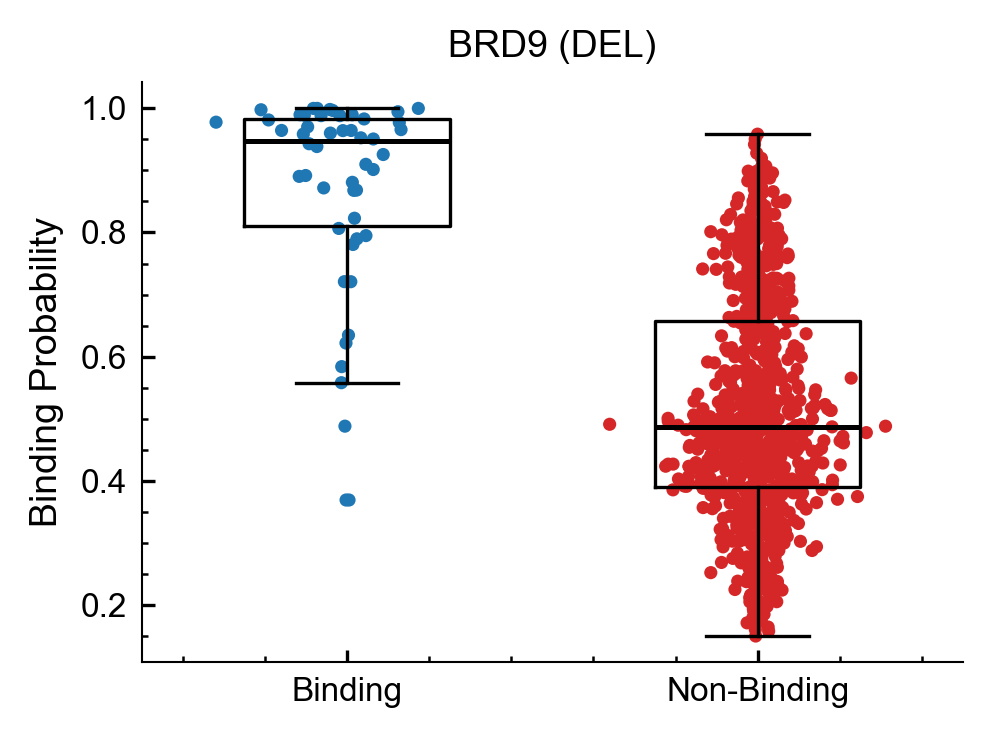

In [15]:
data = [lpredY[:50], lpredY[50:]]
kernels = [stats.gaussian_kde(x) for x in data]
print("kernels")
densities = [kernels[i](data[i]) for i in range(len(data))]
maxes = [max(x) for x in densities]
spreads = [np.array([x/maxes[i] for x in densities[i]]) for i in range(len(data))]
labels=["Binding", "Non-Binding"]
fig, ax = plt.subplots(figsize=(3.35, 2.5))

# Boxplot with higher zorder
bp = ax.boxplot(
    data,
    labels=labels,
    showfliers=False,
    boxprops=dict(linewidth=0.8, color='black', zorder=3),
    whiskerprops=dict(linewidth=0.8, color='black', zorder=3),
    capprops=dict(linewidth=0.8, color='black', zorder=3),
    medianprops=dict(linewidth=1.2, color='black', zorder=3),
    widths=0.5
)

# Scatter points with lower zorder
point_colors = ['#1f77b4', '#d62728']
for i, group_data in enumerate(data):
    #x = np.random.normal(i+1, 0.06, size=len(group_data))
    x = np.random.normal(0, 0.1, size=len(group_data)) * spreads[i] + np.ones(len(group_data)) * (i+1)
    ax.scatter(
        x, group_data,
        color=point_colors[i % 2],
        alpha=1,
        s=10,
        edgecolors='none',
        zorder=2
    )
ax.set_title("BRD9 (DEL)")
ax.set_ylabel("Binding Probability", labelpad=4)
ax.minorticks_on()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
stats.mannwhitneyu(lpredY[:50], lpredY[50:], alternative='greater')

MannwhitneyuResult(statistic=38898.0, pvalue=2.5648198673805387e-23)

In [17]:
sum(lpredY[:50])/len(lpredY[:50]) - sum(lpredY[50:])/len(lpredY[50:])

0.35218541608137244

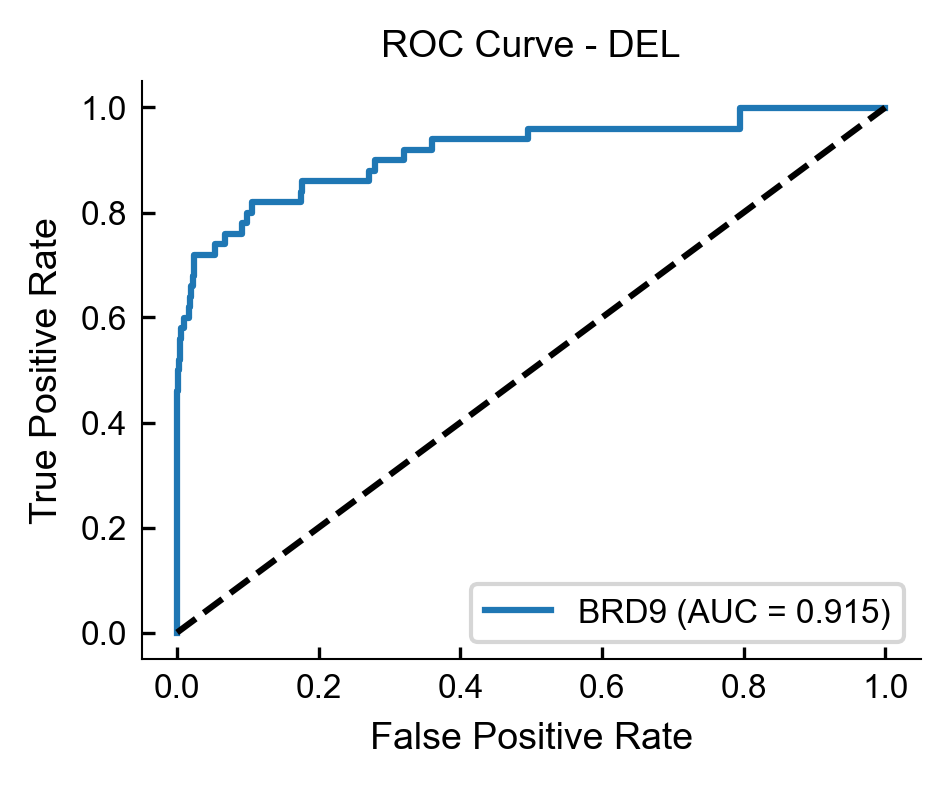

In [18]:
fprs, tprs, _ = roc_curve(testY, predY)
fig, ax = plt.subplots(figsize=(3.35, 2.5))
ax.plot(fprs, tprs, label=f'BRD9 (AUC = {np.round(auc,3)})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - DEL')
ax.legend()

In [19]:
smiles = [deldata["structure"][x] for x in bind] + [deldata["structure"][x] for x in nonbind]

In [20]:
mols = [Chem.MolFromSmiles(x) for x in smiles]
testmols = [mols[i] for i in testindices]

In [21]:
fragments = []
for i in range(len(testmols)):
    frags = BRICS.BRICSDecompose(mols[i], minFragmentSize=5)
    fragments.append(frags)

In [47]:
import re

In [48]:
len(testmols)

900

In [49]:
substruct_dict = {}
off_target = {}
for i in range(len(testmols)):
    frags = fragments[i]
    for ofrag in frags:
        frag = ofrag
        #frag = re.sub(r"\[\d+\*\]", "", ofrag).replace("()", "")
        if frag not in substruct_dict:
            substruct_dict[frag] = []
        substruct_dict[frag].append(predY[i]) 
for frag in substruct_dict.keys():
    try:
        mfrag = Chem.MolFromSmiles(frag)
    except:
        continue
    off_target[frag] = []
    for i in range(len(testmols)):
        if predY[i] in substruct_dict[frag]:
            continue
        if mfrag is not None and (len(mols[i].GetSubstructMatch(mfrag)) != 0):
            substruct_dict[frag].append(predY[i])
        else:
            off_target[frag].append(predY[i])

In [50]:
ranked_subs = sorted(sorted([(k, len(v), (sum(v)/len(v) - sum(off_target[k])/(len(off_target[k]))) if len(off_target[k]) > 0 else 0) for k, v in substruct_dict.items()], key=lambda x:-x[1])[:100], key=lambda x:-x[2])
ranked_subs

[('[16*]c1cnc(O)c(C)c1', 38, 0.14312909564907783),
 ('[16*]c1cnccc1N', 11, 0.11488287747779197),
 ('[1*]C(=O)c1conc1C(C)(C)N[5*]', 19, 0.1071120207183397),
 ('[1*]C(=O)CC1(N[5*])CCC1', 18, 0.10411797338906859),
 ('[1*]C(=O)CC1(N[5*])CCOCC1', 21, 0.08626911151030542),
 ('[1*]C(=O)CCC1(N[5*])CCOC1', 17, 0.08307790285185662),
 ('[1*]C(=O)CC1CCC(N[5*])C1', 11, 0.0815789213600776),
 ('[1*]C(=O)c1csc(C)c1N[5*]', 14, 0.06531097538234165),
 ('[16*]c1cccc(N)c1', 12, 0.06305431472374168),
 ('[4*]Cc1ccccc1', 16, 0.05995425002898769),
 ('[16*]c1ccc2nnn(C)c2c1', 11, 0.059305565863780885),
 ('[1*]C(=O)CCOCCN[5*]', 10, 0.04675715704635486),
 ('[1*]C(=O)C[C@@H]1Cc2ccccc2CN1[5*]', 12, 0.043804171268482905),
 ('[3*]OC(C)(C)C', 15, 0.04265818904000018),
 ('[1*]C(=O)c1ccc2nc(C(C)C)n([9*])c2c1', 152, 0.040714548022481645),
 ('[16*]c1ccc2c(c1)CC(=O)N2', 115, 0.036622502032066684),
 ('[5*]NCc1ccc([16*])cc1', 19, 0.03212293409173417),
 ('[1*]C(=O)[C@H](N[5*])[C@@H]([4*])C', 12, 0.03010259885832467),
 ('[16*]c

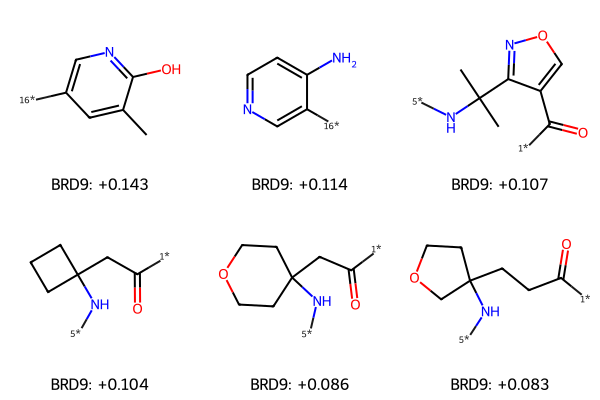

In [53]:
molsMatrix = [[Chem.MolFromSmiles(x[0]) for x in ranked_subs[:10]]]
legendsMatrix = [["BRD9" + ": +" + str(x[2])[:5] for x in ranked_subs[:10]]]
MolsMatrixToGridImage(molsMatrix=[molsMatrix[0][:3], molsMatrix[0][3:6]], legendsMatrix=[legendsMatrix[0][:3], legendsMatrix[0][3:6]])